# 사전 훈련된 컨브넷 사용

- 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것이다.
- 사전 훈련된 네트워크는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크이다.
- 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있다.
- 새로운 문제가 원래 작업과 완전히 다른 클래스에 대한 것이더라도 이런 특성은 많은 컴퓨터 비전 문제에 유용하다.
  - 예를 들어 (대부분 동물이나 생활 용품으로 이루어진) ImageNet 데이터셋에 네트워크를 훈련한 다음 이 네트워크를 이미지에서 가구 아이템을 식별하는 것 같은 다른 용도로 사용할 수 있다.
- 학습된 특성을 다른 문제에 적용할 수 있는 이런 유연성은 이전의 많은 얕은 학습 방법과 비교했을 때 딥러닝의 핵심 장점이다.
- 이런 방식으로 작은 데이터셋을 가진 문제에도 딥러닝이 효율적으로 작동할 수 있다.<br><br>

여기에서는 (1.4백만 개의 레이블된 이미지와 1,000개의 클래스로 이루어진) ImageNet 데이터셋에서 훈련된 대규모 컨브넷을 사용한다.

ImageNet 데이터셋은 다양한 종의 강아지와 고양이를 포함해 많은 동물들을 포함하고 있으며 강아지 vs. 고양이 분류 문제에 좋은 성능을 낼 수 있다.<br><br>

- VGG16(캐런 시몬연과 앤드류 지서먼이 2014년에 개발)은 간단하고 ImageNet 데이터셋에 널리 사용되는 컨브넷 구조이다.
- VGG16은 조금 오래되었고 최고 수준의 성능에는 못미치며 최근의 다른 모델보다는 조금 무겁다.<br><br>


사전 훈련된 네트워크는 2가지 방법으로 사용할 수 있다.

- 특성 추출(feature extraction) : 새로운 데이터셋에 기존 컨브넷을 쉽게 재사용
  - 데이터 증식을 사용하지 않는 빠른 특성 추출 - 새로운 데이터 셋에서 합성곱 기반 층을 실행하고 출력을 넘파이 배열로 디스크에 저장한 다음 이 데이터를 완전 연결 분류기에 입력으로 사용
  - 데이터 증식을 사용한 특성 추출 - 준비한 모델(conv_base) 위에 Dense 층을 쌓아 확장
- 미세 조정(fine tuning) : 특성 추출을 보완하는 방법으로 기존 모델에서 사전에 학습한 표현의 일부를 새로운 문제에 적응

## 특성 추출

특성 추출은 사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 흥미로운 특성을 뽑아 내는 것이다. 

이런 특성을 사용하여 새로운 분류기를 처음부터 훈련한다.

컨브넷은 이미지 분류를 위해 두 부분으로 구성된다. 먼저 연속된 합성곱과 pooling 층으로 시작해서 완전 연결 분류기로 끝난다.
- 합성곱 기반층(convolutional base) : 합성곱과 pooling 층으로 구성
- 완전 연결 분류기

컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반 층을 선택하여 새로운 데이터를 통과시키고, 그 출력으로 새로운 분류기를 훈련한다.

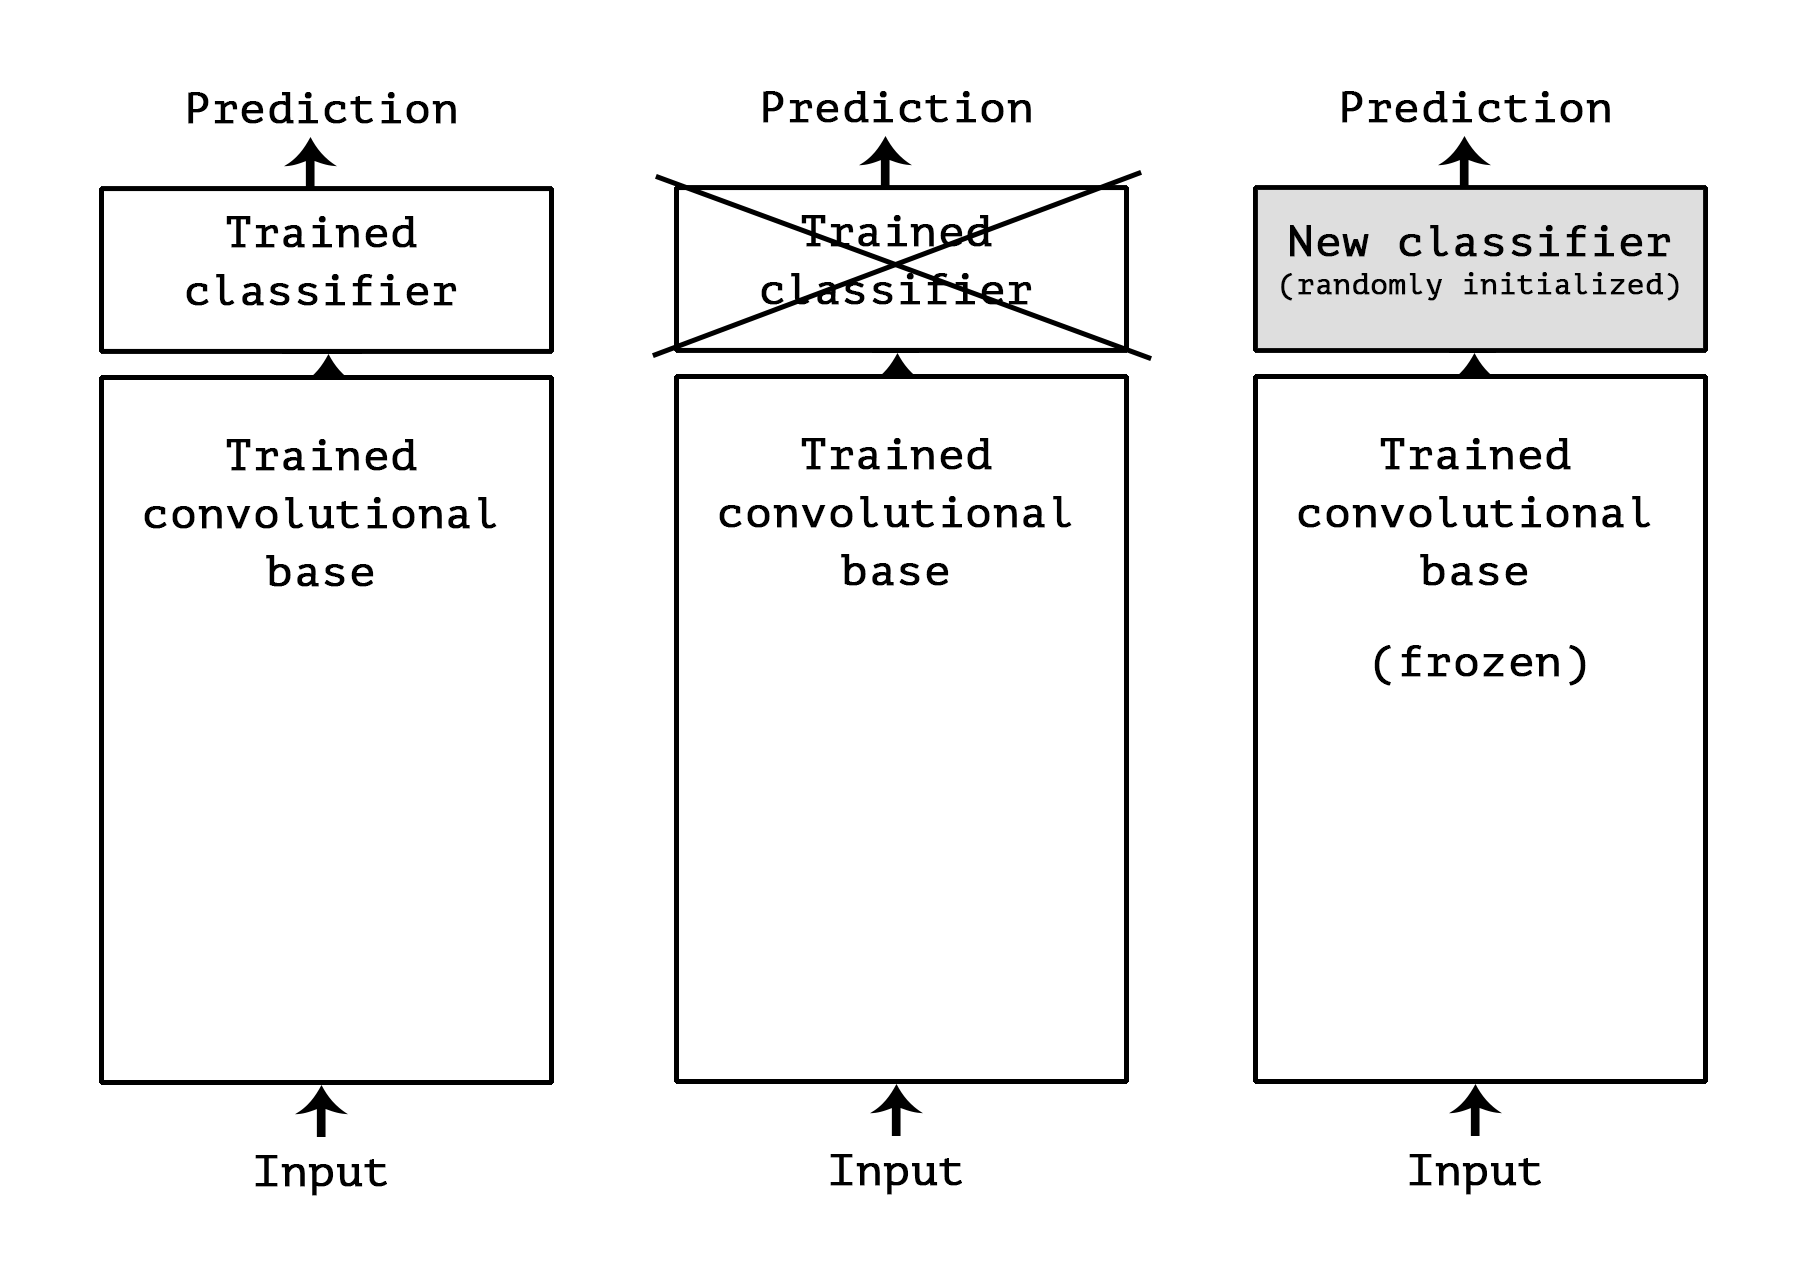

In [8]:
from IPython.display import Image
Image('/content/drive/MyDrive/cakd5_colab/m9_딥러닝알고리즘구현/datasets/feature extraction.png')

## 왜 합성곱 층만 재사용할까? 완전 연결 분류기는 재사용하면 안되는가? 

일반적으로 완전 연결 분류기 재사용은 권장하지 않고 있다. 그 이유는 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용이 가능하기 때문이다.

컨브넷의 특성 맵은 사진에 대한 일반적인 컨셉의 존재 여부를 기록한 맵이다.

그래서 주어진 컴퓨터 비전 문제에 상관없이 유용하게 사용할 수 있다.

하지만 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있다.

분류기는 전체 사진에 어떤 클래스가 존재할 확률에 관한 정보만을 담고 있다.
 
더군다나 완전 연결 층에서 찾은 표현은 더 이상 입력 이미지에 있는 객체의 위치 정보를 가지고 있지 않는다. 

완전 연결 층들은 공간 개념을 제거하지만 합성곱의 특성 맵은 객체의 위치를 고려한다.

객체의 위치가 중요한 문제라면 완전 연결 층에서 만든 특성은 크게 쓸모가 없다.<br><br>


특정 합성곱 층에서 추출한 표현의 일반성 및 재사용성 수준은 모델에 있는 층의 깊이에 따라 달려있다. 


모델의 하위 층은 (에지, 색깔, 질감 등과 같이) 지역적이고 매우 일반적인 특성 맵을 추출한다.


반면 상위 층은 ('강아지 눈'이나 '고양이 귀'와 같이) 좀 더 추상적인 개념을 추출한다. 


만약 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 전체 합성곱 기반층을 사용하는 것보다는 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋다.<br><br>


ImageNet의 클래스 집합에는 여러 종류의 강아지와 고양이를 포함하고 있다. 

이런 경우 원본 모델의 완전 연결 층에 있는 정보를 재사용하는 것이 도움이 될 것 이다. 

하지만 새로운 문제의 클래스가 원본 모델의 클래스 집합과 겹치지 않는 좀 더 일반적인 경우를 다루기 위해서 여기서는 완전 연결 층을 사용하지 않는다.


ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출한다. 

그런 다음 이 특성으로 강아지 vs 고양이 분류기를 훈련한다.

VGG16 모델은 keras 패키지로 존재하며 keras.applications 모듈에서 import 할 수 있다. 이 모듈에서 사용가능한 이미지 분류 모델은 다음과 같다.

- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet

에러 발생시 keras, tensorflow uninstall 후 아래와 같이 버전 install
- 삭제
  - pip uninstall tensorflow
  - pip uninstall keras
- 설치
  - !pip install keras==2.3.1
  - !pip install tensorflow==2.2.0

In [ ]:
!pip install keras==2.3.1
!pip install tensorflow==2.2.0

In [10]:
# VGG16 합성곱 기반 층 생성
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

ImportError: ignored

VGG16 함수에서는 3개의 매개변수를 전달한다.
- weights는 모델을 초기화할 가중치 체크포인트를 지정한다.

- include_top은 네트워크의 최상위 완전 연결 분류기를 포함할지 안할지를 지정한다. 기본값은 ImageNet의 1,000개의 클래스에 대응되는 완전 연결 분류기를 포함한다. 별도의 (강아지와 고양이 두 개의 클래스를 구분하는) 완전 연결 층을 추가하려고 하므로 이를 포함시키지 않는다.

- input_shape은 네트워크에 주입할 이미지 텐서의 크기이다. 이 매개변수는 선택사항이다. 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있다.

In [ ]:
# VGG16 합성곱 기반층의 구조
conv_base.summary()

최종 특성 맵의 크기는 (4, 4, 512)이다. 이 특성 위에 완전 연결 층은 2가지 방식으로 놓을 수 있다.

- 새로운 데이터셋에서 합성곱 기반층을 실행하고 출력을 넘파이 배열로 디스크에 저장한다. 그다음 이 데이터를 독립된 완전 연결 분류기에 입력으로 사용한다. 이 방식에서는 합성곱 기반 층을 한번만 실행하기 때문에 빠르고 비용이 적게 든다. 하지만 데이터 증식을 사용할 수 없다.

- 준비한 모델(conv_base) 위에 Dense 층을 쌓아 확장한다. 그리고 입력 데이터에서 엔드-투-엔드로 전체 모델을 실행한다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식을 사용할 수 있다. 하지만 이런 이유로 이 방식은 첫 번째 방식보다 훨씬 비용이 많이 든다.

# 데이터 증식을 사용하지 않고 빠른 특성 추출
ImageDatagenerator를 사용하여 이미지와 레이블을 넘파이 배열로 추출한다. conv_base 모델의 predict 메서드를 호출하여 이 이미지에서 특성을 추출한다.

추출된 특성의 크기는 (samples, 4, 4, 512)이기에 완전 연결 분류기에 넣기 위해 (samples, 8192)크기로 펼친다.

In [ ]:
# 사전 훈련된 합성곱 기반 층을 사용한 특성 추출하고 특성맵 펼치기
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지한다.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

추출된 특성의 크기는 (samples, 4, 4, 512)이다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼친다.

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

그러고 나서 완전 연결 분류기를 정의하고(규제를 위해 드롭아웃을 사용) 저장된 데이터와 레이블을 사용해 훈련한다.

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

두 개의 Dense 층만 처리하면 되기 때문에 훈련이 매우 빠르다. CPU를 사용하더라도 한 에포크에 걸리는 시간이 1초 미만이다.



In [ ]:
# 훈련 손실과 정확도 곡선 시각화

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

약 90%의 검증 정확도에 도달했다. 이전 예제에서 처음부터 훈련시킨 작은 모델에서 얻은 것보다 훨씬 좋다. 


하지만 이 그래프는 많은 비율로 드롭아웃을 사용했음에도 불구하고 훈련이 시작하면서 거의 바로 과대적합되고 있다는 것을 보여준다. 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문이다.

# 데이터 증식을 사용하여 모델 훈련

이제 특성 추출을 위해 두 번째 방법을 살펴본다. 이 방법은 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법을 사용할 수 있습니다. conv_base 모델을 확장하고 입력 데이터를 사용해 엔드 투 엔드로 실행한다.


이 기법은 연산 비용이 크기 때문에 GPU를 사용할 수 있을 때 시도해야 한다. CPU에서는 적용하기 매우 힘들다.


모델은 층과 동일하게 작동하므로 층을 추가하듯이 Sequential 모델에 (conv_base 같은) 다른 모델을 추가할 수 있다.

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# 모델 구조 확인
model.summary()

여기서 볼 수 있듯이 VGG16의 합성곱 기반층은 14,714,688개의 매우 많은 파라미터를 가지고 있다. 합성곱 기반층 위에 추가한 분류기는 2백만개의 파라미터를 가진다.


모델을 컴파일하고 훈련하기 전에 합성곱 기반층을 동결하는 것이 아주 중요하다. 


하나 이상의 층을 동결한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻이다.


이렇게 하지 않으면 합성곱 기반층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것이다.


맨 위의 Dense 층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것이다. 이는 사전에 학습된 표현을 크게 훼손하게 된다.

keras에서는 trainable 속성을 False로 설정하여 네트워크를 동결할 수 있다.

In [ ]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

In [ ]:
conv_base.trainable = False

In [ ]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

이렇게 설정하면 추가한 두 개의 Dense 층의 가중치만 훈련될 것이다.


층마다 두 개씩(가중치 행렬과 편향 벡터) 총 네 개의 텐서가 훈련된다.


변경 사항을 적용하려면 먼저 모델을 컴파일해야 한다.


컴파일 단계 후에 trainable 속성을 변경하면 반드시 모델을 다시 컴파일해야 한다. 그렇지 않으면 변경 사항이 적용되지 않는다.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안된다.
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경한다.
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요하다.
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

In [ ]:
model.save('cats_and_dogs_small_3.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

여기서 볼 수 있듯이 검증 정확도가 이전과 비슷하지만 처음부터 훈련시킨 소규모 컨브넷보다 과대적합이 줄었다.

# 미세조정

모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정이다.


미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것이다.


주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라고 부른다.

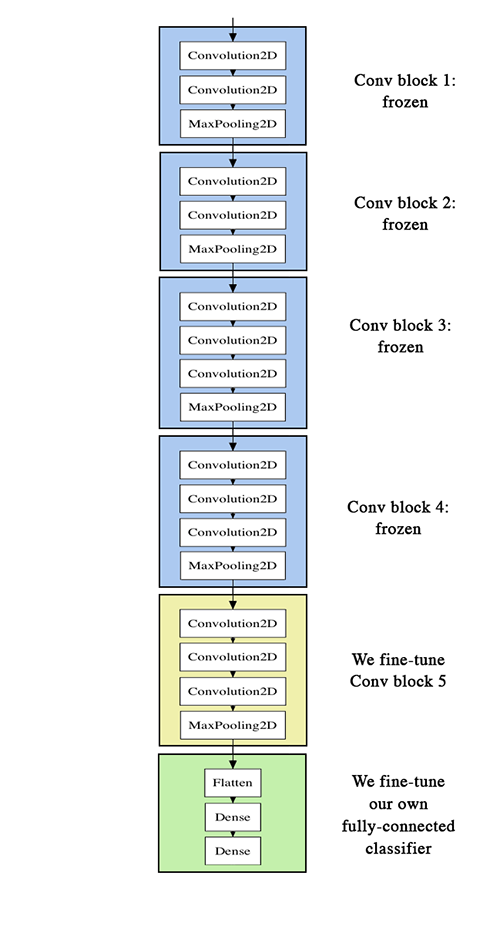

In [9]:
from IPython.display import Image
Image('/content/drive/MyDrive/cakd5_colab/m9_딥러닝알고리즘구현/datasets/fine-tuning.png')